In [50]:
import sys
import numpy as np
import pandas as pd
from scipy import stats
from os import listdir
import seaborn as sns ;sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from datetime import datetime
import time
%matplotlib inline

# Object for query data

In [74]:
class Query_data:
    def __init__(self):
        self.all_table = listdir('./data_new')
        
        self.pick_table = {}   # {file name : dataframe}
        self.exited_table = {} # {no : filename}
        self.table_no = 0
        
        self.SQL_table = {} # {file name : Queried dataframe}
        self.SQL_table_no = 0
        self.SQL_table_info = {}
        
        self.SQL_data = {}    # {data_no : data}
        self.SQL_data_no = 0
        self.SQL_data_info = {} # {no : (file name, data name)}

        
        
    def load_table(self, filename):
        '''Load file & Reset the index by timeline'''
        if isinstance(filename, list):
            for file in filename:
                self.pick_table[file] = pd.read_csv('./data_new/'+file)
                time = self.pick_table[file][self.pick_table[file].columns[0]]
                time = pd.to_datetime(time)
                self.pick_table[file] = self.pick_table[file].set_index(time, drop=True)
                del self.pick_table[file][self.pick_table[file].columns[0]]
                self.table_no += 1
                self.exited_table[self.table_no] = file
                
        elif isinstance(filename, str):
            self.pick_table[filename] = pd.read_csv('./data_new/'+filename)
            time = self.pick_table[filename][self.pick_table[filename].columns[0]]
            time = pd.to_datetime(time)
            self.pick_table[filename] = self.pick_table[filename].set_index(time, drop=True)
            del self.pick_table[filename][self.pick_table[filename].columns[0]]
            self.table_no += 1
            self.exited_table[self.table_no] = filename
        else:
            print('Enter a filename(string) of a list with file (string)')
 

            
  
    def groupby_table(self, FROM='', WHERE='whole', HOUR='whole', GROUP='no'):
        
        if WHERE == 'holiday' or WHERE == 'workday':
            timeline = pd.read_csv('./data_new/'+ WHERE +'_106.csv')
            timeline = pd.to_datetime(timeline[timeline.columns[0]].values)
            
            holiday = np.zeros(len(self.pick_table[FROM]))
            for i in range(len(timeline.date)):
                tt = self.pick_table[FROM].index.date == timeline.date[i] 
                holiday = holiday + tt
            temp= self.pick_table[FROM][np.bool_(holiday)]
                 
        else:
            if WHERE == 'whole':
                WHERE = ['2017/1/1 00:00:00', '2017/12/31 23:55:00']
                print('Take {} whole date'.format(FROM))


            # take date
            temp = self.pick_table[FROM][self.pick_table[FROM].index  >= pd.to_datetime(WHERE[0])]
            temp = temp[temp.index <= pd.to_datetime(WHERE[1])]
        
        
        if HOUR == 'whole':
            HOUR = [0, 23]
            print('Take {} 24hr'.format(FROM))
        # take hour period & save to a dict.
        temp = temp[temp.index.hour >= HOUR[0]]
        self.SQL_table_no += 1
        self.SQL_table[self.SQL_table_no] = temp[temp.index.hour <= HOUR[1]]
        
        # groupby operation
        if GROUP == 'no':
            self.SQL_table_info[self.SQL_table_no] = (FROM, WHERE, 'No Groupby')
            return 0
            
        else:
            group_dict = {'date' :self.SQL_table[self.SQL_table_no].index.date,
                          'month':self.SQL_table[self.SQL_table_no].index.month,
                        'weekday':self.SQL_table[self.SQL_table_no].index.weekday,
                          'week' :self.SQL_table[self.SQL_table_no].index.week,
                          'day'  :self.SQL_table[self.SQL_table_no].index.day,
                          'hour' :self.SQL_table[self.SQL_table_no].index.hour     
                          }
            if GROUP[1] == 0:
                self.SQL_table[self.SQL_table_no] = self.SQL_table[self.SQL_table_no].groupby(group_dict[GROUP[0]])
            else:
                self.SQL_table[self.SQL_table_no] = self.SQL_table[self.SQL_table_no]\
                                                    .groupby([group_dict[GROUP[0]], group_dict[GROUP[1]]])
            calculate = {'sum'   : self.SQL_table[self.SQL_table_no].sum(),
                         'max'   : self.SQL_table[self.SQL_table_no].max(),
                         'min'   : self.SQL_table[self.SQL_table_no].min(),
                         'std'   : self.SQL_table[self.SQL_table_no].std(),
                         'var'   : self.SQL_table[self.SQL_table_no].var(),
                         'mean'  : self.SQL_table[self.SQL_table_no].mean(),
                         'median': self.SQL_table[self.SQL_table_no].median()
                         }
            self.SQL_table[self.SQL_table_no] = calculate[GROUP[2]]
            self.SQL_table_info[self.SQL_table_no] = (FROM, WHERE, GROUP)
            return 
        
        
    
    def del_SQL_table(self, no=0):
        if int(max(self.SQL_table.keys())) == int(no):
            del self.SQL_table[no]
            del self.SQL_table_info[no]
            self.SQL_table_no -= 1
            return print(self.SQL_table_info)
        elif no in self.SQL_table.keys():
            for i in range(no, len(self.SQL_table)):
                self.SQL_table[i] = self.SQL_table[i+1] # {file name : Queried dataframe}
                self.SQL_table_info[i] = self.SQL_table_info[i+1]
                del self.SQL_table[i+1]
                del self.SQL_table_info[i+1]
                self.SQL_table_no -= 1
            return print(self.SQL_table_info)
        else:
            print('some thing wrong')
 


'''        
    def join_SQLtable(self, **kwargs):
        new_pd = pd.DataFrame()
        
        for k, v in kwargs.items():
            SELECT = v[0]
            self.groupby_table(FROM=v[1], WHERE=v[2], HOUR=v[3], GROUP=v[4])
            new_pd = pd.concat([new_pd, self.SQL_table[self.SQL_table_no][SELECT]], axis=1)
            self.del_SQL_table[self.SQL_table_no]
        
        self.SQL_table_no += 1
        self.SQL_table[self.SQL_table_no] = new_pd
'''

'        \n    def join_SQLtable(self, **kwargs):\n        new_pd = pd.DataFrame()\n        \n        for k, v in kwargs.items():\n            SELECT = v[0]\n            self.groupby_table(FROM=v[1], WHERE=v[2], HOUR=v[3], GROUP=v[4])\n            new_pd = pd.concat([new_pd, self.SQL_table[self.SQL_table_no][SELECT]], axis=1)\n            self.del_SQL_table[self.SQL_table_no]\n        \n        self.SQL_table_no += 1\n        self.SQL_table[self.SQL_table_no] = new_pd\n'

# Table Basic Statistic & Visualize

In [75]:
class Table_sta_vis:
    def __init__(self):
        self.strat = datetime.today()
        self.markers=['o', 's', 'D', 'x', '<', '^', '+']*10
        self.rc={'axes.labelsize': 26, 'font.size': 32, 'legend.fontsize': 32.0, 'axes.titlesize': 32}
        
    def line(self, table, title='', size=(20,8)):
        table.plot(kind='line',title=title, figsize=size)
        #sns.set_context(rc=self.rc)
        
        
    def bar(self, table, size=(20, 8), stacked=True):
        table.plot(kind='bar',figsize=size, stacked=stacked)
        #sns.set_context(rc=self.rc)
        
    def area(self, table, size=(20, 8), stacked=True):
        table.plot(kind='area',title='',figsize=size, stacked=stacked)
        #sns.set_context(rc=self.rc)
        
    def box(self, table):
        sns.boxplot(data=table, palette="Set1")
        #sns.set_context(rc=self.rc)
    
    def pairplot(self, table):
        sns.pairplot(table, diag_kind="hist")
        #sns.set_context(rc=self.rc)
        #plt.show()

# Data Basic Statistic & Visualize

In [76]:
class Visualize:
    def __init__(self):
        self.strat = datetime.today()
        
    def line_plot(self, all_SQLdata, size=(10, 4)):
        '''Line plot & put all data in one figure'''
        plt.style.use('seaborn-bright')
        fig, ax = plt.subplots(figsize=size)
        
        if isinstance(all_SQLdata, dict) is not True:
            print('Enter data must be a dict. with muti data')
        else:
            xx = {}
            for i in all_SQLdata:
                xx[i] = [g for g in range(len(all_SQLdata[i]))]
                plt.plot(xx[i], all_SQLdata[i],lw=3)
            plt.show()
            
            
    def lollipop(self, all_SQLdata, size=(16,6)):
        plt.style.use('seaborn-bright')
        fig, ax = plt.subplots(figsize=size)
        
        if isinstance(all_SQLdata, dict) is not True:
            print('Enter data must be a dict with muti data')
        else:
            for i in all_SQLdata:
                plt.stem(all_SQLdata[i], c=i)
        plt.show()
        
        
        
    def boxplot(self, all_SQLdata, size=(10, 16)):
        plt.style.use('seaborn-bright')
        fig, ax = plt.subplots(figsize=size)
        
        if isinstance(all_SQLdata, dict) is not True:
            print('Enter data must be a dict with muti data')
        else:
            data = []
            posi = []
            for i in all_SQLdata:
                data.append(list(all_SQLdata[i]))
                posi.append(i*1.5)
            plt.boxplot(data, positions = posi, widths = 0.6)
            plt.show()

# Statistic

In [77]:
class Statistic:
    
    def __init__(self):
        self.corr = {}
        
    def auto_corr(self, all_SQLdata, size=(18, 6)):
        plt.style.use('seaborn-bright')
        fig, ax = plt.subplots(figsize=size)
        for i in all_SQLdata:
            norm = np.sum(all_SQLdata[i].values ** 2)
            self.corr[i] = np.correlate(all_SQLdata[i].values, all_SQLdata[i].values, mode='full') / norm
            plt.stem(self.corr[i][len(all_SQLdata[i].values)-1:], c=i)
        plt.show()
        
        
    def correction(self, all_SQLdata):     
        stats.pearsonr(a, b)  

### 基本：
* 自變 / 應變
* 比較 / 變化 / 構成
1. 平均(算術/幾何) / 眾數  / 中位  / 全距  / 四分位差  /  變異  / 標準差
2. cv(變異係數)  /  峰態：k=3 四次方  /  偏態 中位數 正負值
3. 自相關 auto corr. / 自我迴歸
4. 相似 


### 進階：
* 關聯性：高耗電之變數關聯性
* 分群：不同用電的用電模式
* 分類：(SVM/Logistic Regression): X: 冰機/幫浦; y:耗電量高/普通
* 平衡點(最佳解問題)：

### HVAC 診斷
1. 震盪：定義震盪: 各種溫差 / 壓差
2. 長期負載不要太高或太低(一般50%左右/計算？)  熱負載低 => 流量低 => 耗電低
3. 夜間外氣交換是否有開  /  日間外氣開啟的平衡點。
4. 機器運轉時間
5. 最佳水泵水量與冰水溫度(冰水泵流量降低時耗電量下降 / 冰水主機效率則因蒸發溫度下降而降低)
6. 冰水泵耗電 / 主機耗電 
7. 冷卻水溫度降低，冰機耗電降低，但冷卻水塔耗電增加
8. 水溫度和氣溫/星期幾/時段....等關係
9. 主機台數 / 運轉負載 / 冰水進出溫度
10. 高低耗電與 對應數值和為

![](./image/air.png)

![](./image/air2.png)

In [89]:
qd = Query_data() #呼叫物件
listdir('./data_new')

['R_1_冰水機.csv',
 '中央冰水系統.csv',
 'TR_01_電梯消防幫浦配電盤.csv',
 'ZP_4_冰水幫浦.csv',
 'TR_04_南側照明插座配電盤.csv',
 'ZP_7_冰水幫浦.csv',
 'ZP_2_冰水幫浦.csv',
 'CT_3_冷卻水塔.csv',
 'CT_5_冷卻水塔.csv',
 'workday_106.csv',
 'R_7_冰水機.csv',
 '配電盤用電.csv',
 'TR_02_PUS消防排煙配電盤.csv',
 'TR_05_北側照明插座配電盤.csv',
 'TR_09_北側AHU_CT14_CHP配電盤.csv',
 'R_6_冰水機.csv',
 'TR_10_南側AHU_CT58_ZP配電盤.csv',
 'TR_08_冰水機CWP幫浦配電盤.csv',
 'CT_2_冷卻水塔.csv',
 'CT_6_冷卻水塔.csv',
 'CT_7_冷卻水塔.csv',
 'R_5_冰水機.csv',
 '設備用電_hour.csv',
 'ZP_6_冰水幫浦.csv',
 '行政用電_hour.csv',
 'CT_4_冷卻水塔.csv',
 'R_4_冰水機.csv',
 'ZP_8_冰水幫浦.csv',
 'TR_07_冰水機CWP幫浦配電盤.csv',
 'R_2_冰水機.csv',
 '設備用電.csv',
 '行政用電.csv',
 'CT_8_冷卻水塔.csv',
 'holiday_106.csv',
 'TR_03_南側照明插座配電盤.csv',
 'CT_1_冷卻水塔.csv',
 'R_3_冰水機.csv',
 'ZP_5_冰水幫浦.csv',
 'TR_06_北側照明插座配電盤.csv',
 '配電盤用電_hour.csv',
 'ZP_3_冰水幫浦.csv',
 'ZP_1_冰水幫浦.csv']

In [90]:
# Read table
qd.load_table(['行政用電.csv', '行政用電_hour.csv'])

In [91]:
qd.pick_table['行政用電.csv'].columns

Index(['空調總用電量(kW)', '照明及插座總用電量(kW)', '雜項及緊急動力總用電量(kW)'], dtype='object')

# 假日(每小時用電)

In [92]:
tStart = time.time()#計時開始
# Check kw value (per 5min.)
qd.groupby_table(FROM='行政用電_hour.csv', 
                 WHERE='holiday',  # 'holiday' or 'workday'
                 HOUR=[7, 16], 
                 GROUP=['date', 0, 'sum'])
tEnd = time.time()#計時結束
print(tEnd - tStart)
qd.SQL_table_info

1.610525131225586


{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum'])}

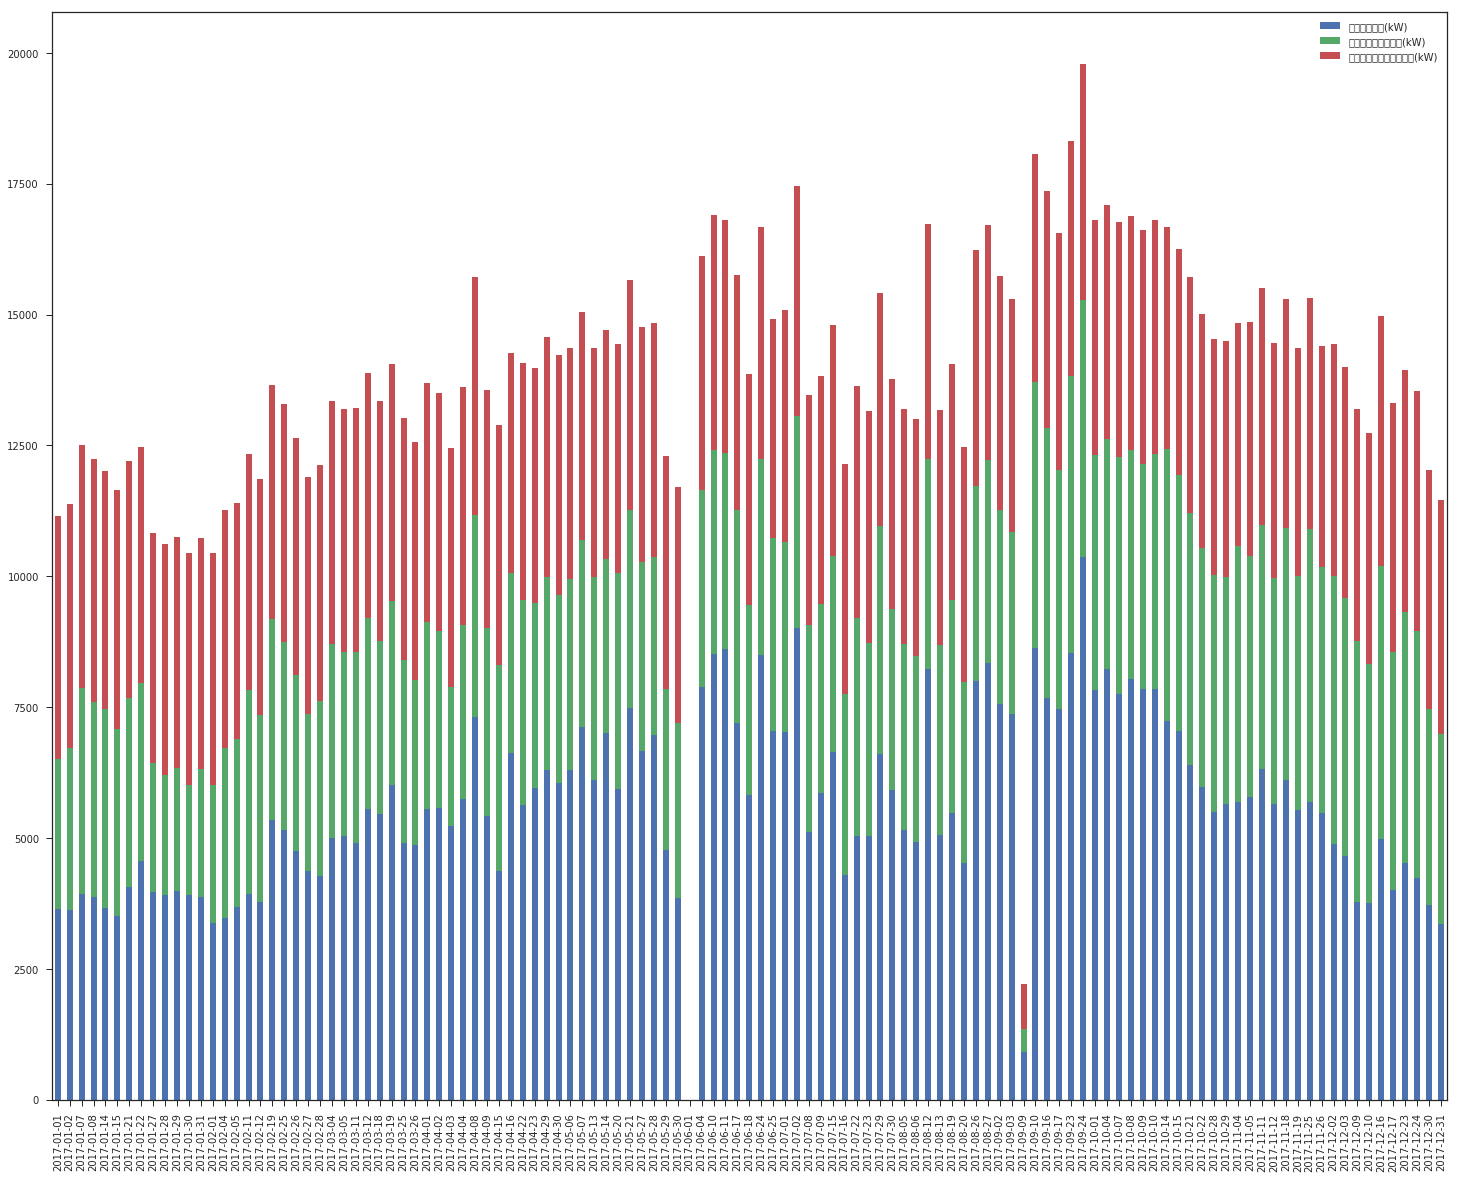

In [93]:
tableV = Table_sta_vis()
tableV.bar(qd.SQL_table[1], size=(25,20), stacked=True)

# 工作日(每小時用電)

In [94]:
tStart = time.time()#計時開始
# Check kw value (per 5min.)
qd.groupby_table(FROM='行政用電_hour.csv', 
                 WHERE='workday',  # 'holiday' or 'workday'
                 HOUR=[7, 16], 
                 GROUP=['date', 0, 'sum'])
tEnd = time.time()#計時結束
print(tEnd - tStart)
qd.SQL_table_info

3.646010160446167


{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum']),
 2: ('行政用電_hour.csv', 'workday', ['date', 0, 'sum'])}

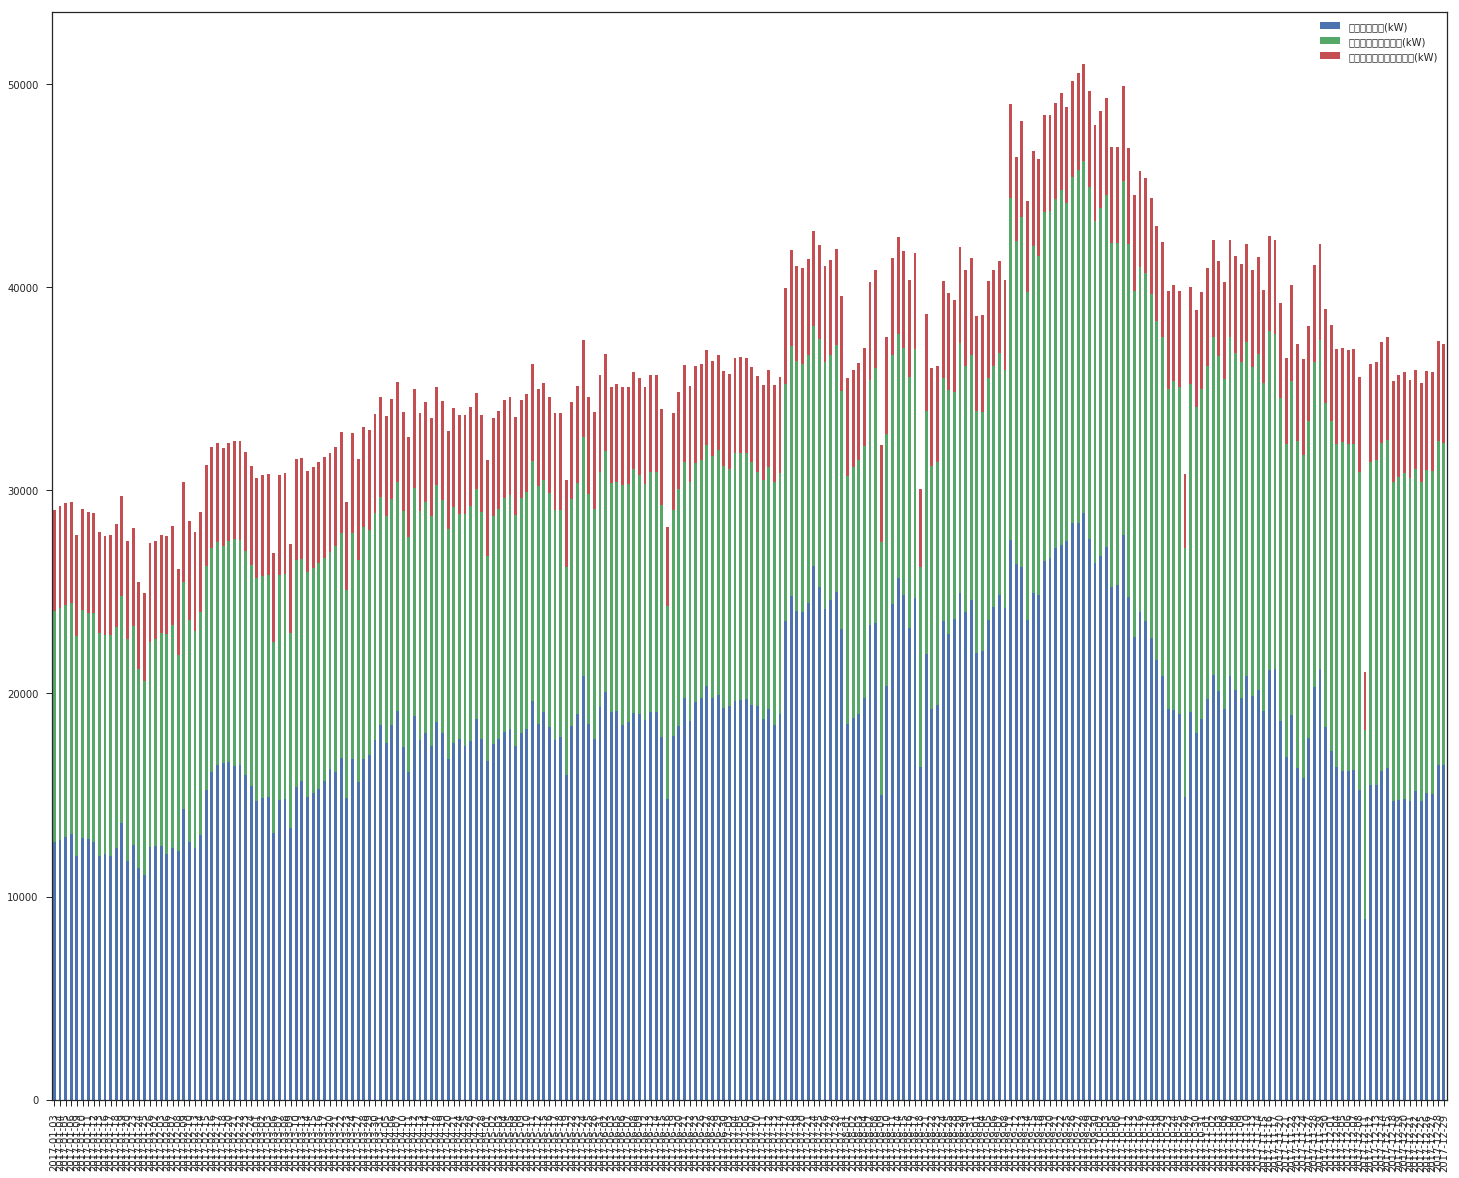

In [95]:
tableV = Table_sta_vis()
tableV.bar(qd.SQL_table[2], size=(25,20), stacked=True)

# 假日取每五分鐘的功率 (我的要花21秒)

In [96]:
tStart = time.time()#計時開始
# Check kw value (per 5min.)
qd.groupby_table(FROM='行政用電.csv', 
                 WHERE='holiday',  # 'holiday' or 'workday'
                 HOUR=[7, 16], 
                 GROUP=['date', 0, 'sum'])
tEnd = time.time()#計時結束
print(tEnd - tStart)
qd.SQL_table_info

21.33409881591797


{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum']),
 2: ('行政用電_hour.csv', 'workday', ['date', 0, 'sum']),
 3: ('行政用電.csv', 'holiday', ['date', 0, 'sum'])}

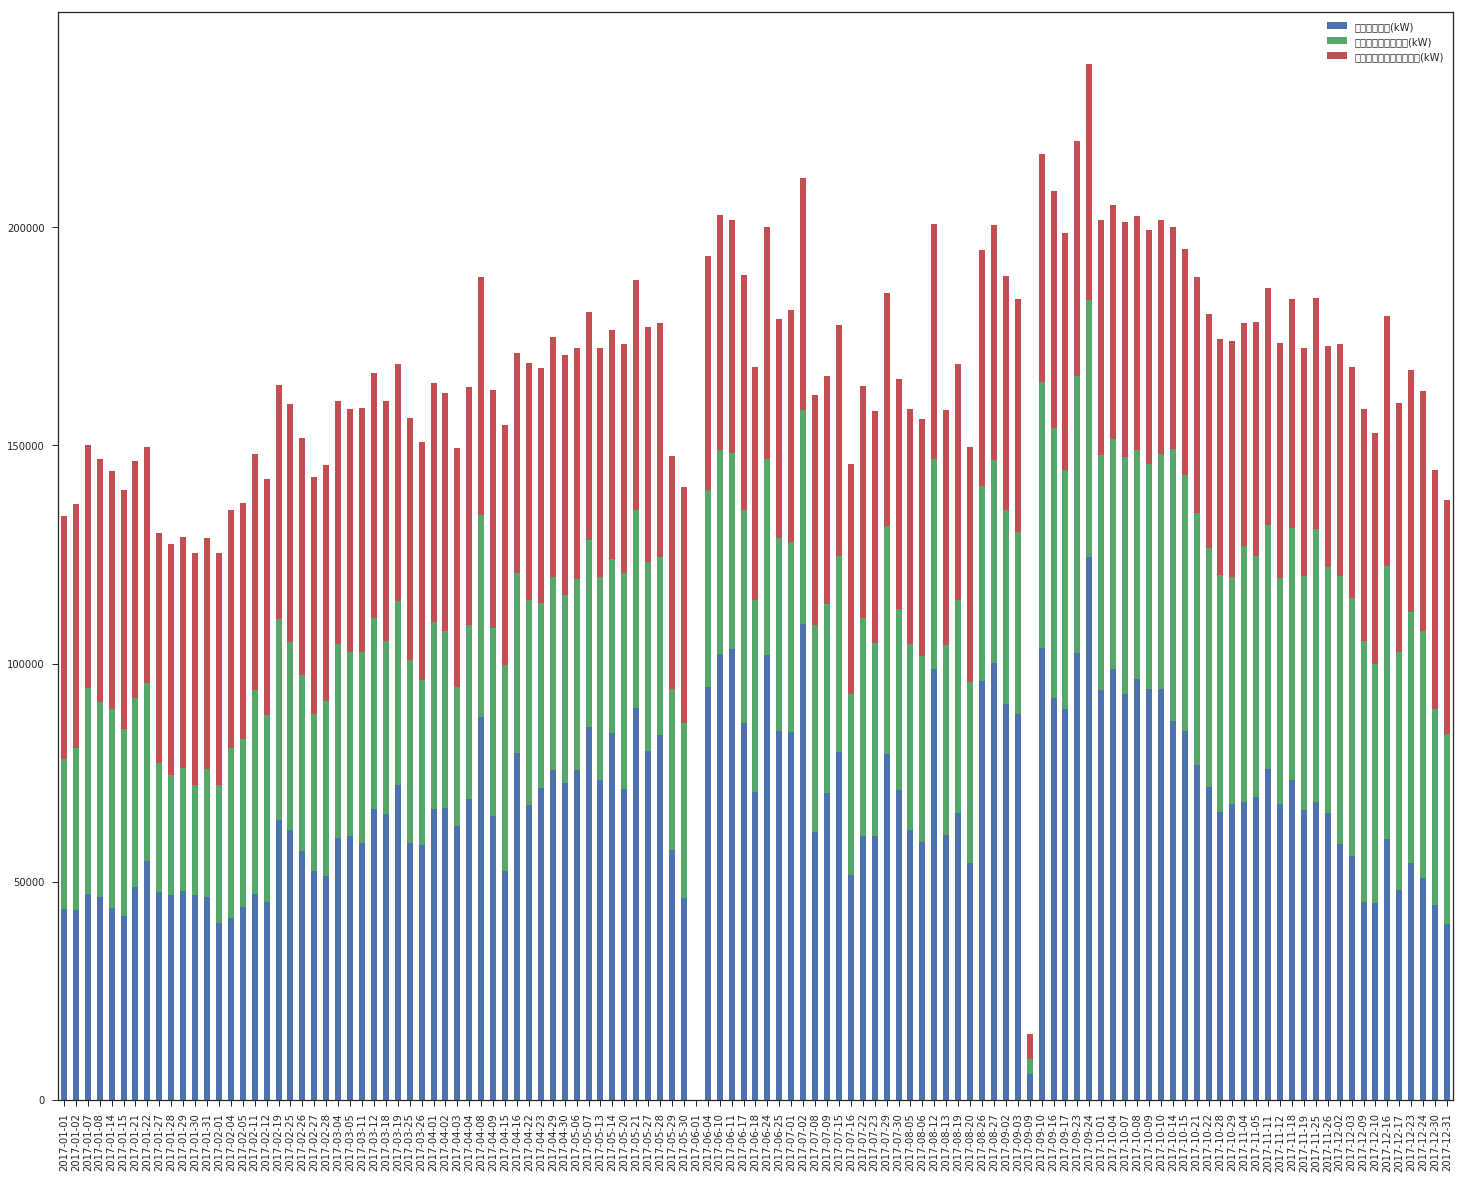

In [97]:
tableV = Table_sta_vis()
tableV.bar(qd.SQL_table[3], size=(25,20), stacked=True)

# 工作日取每五分鐘的功率 (我的要花47秒)

In [98]:
tStart = time.time()#計時開始
# Check kw value (per 5min.)
qd.groupby_table(FROM='行政用電.csv', 
                 WHERE='workday',  # 'holiday' or 'workday'
                 HOUR=[7, 16], 
                 GROUP=['date', 0, 'sum'])
tEnd = time.time()#計時結束
print(tEnd - tStart)
qd.SQL_table_info

47.350464820861816


{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum']),
 2: ('行政用電_hour.csv', 'workday', ['date', 0, 'sum']),
 3: ('行政用電.csv', 'holiday', ['date', 0, 'sum']),
 4: ('行政用電.csv', 'workday', ['date', 0, 'sum'])}

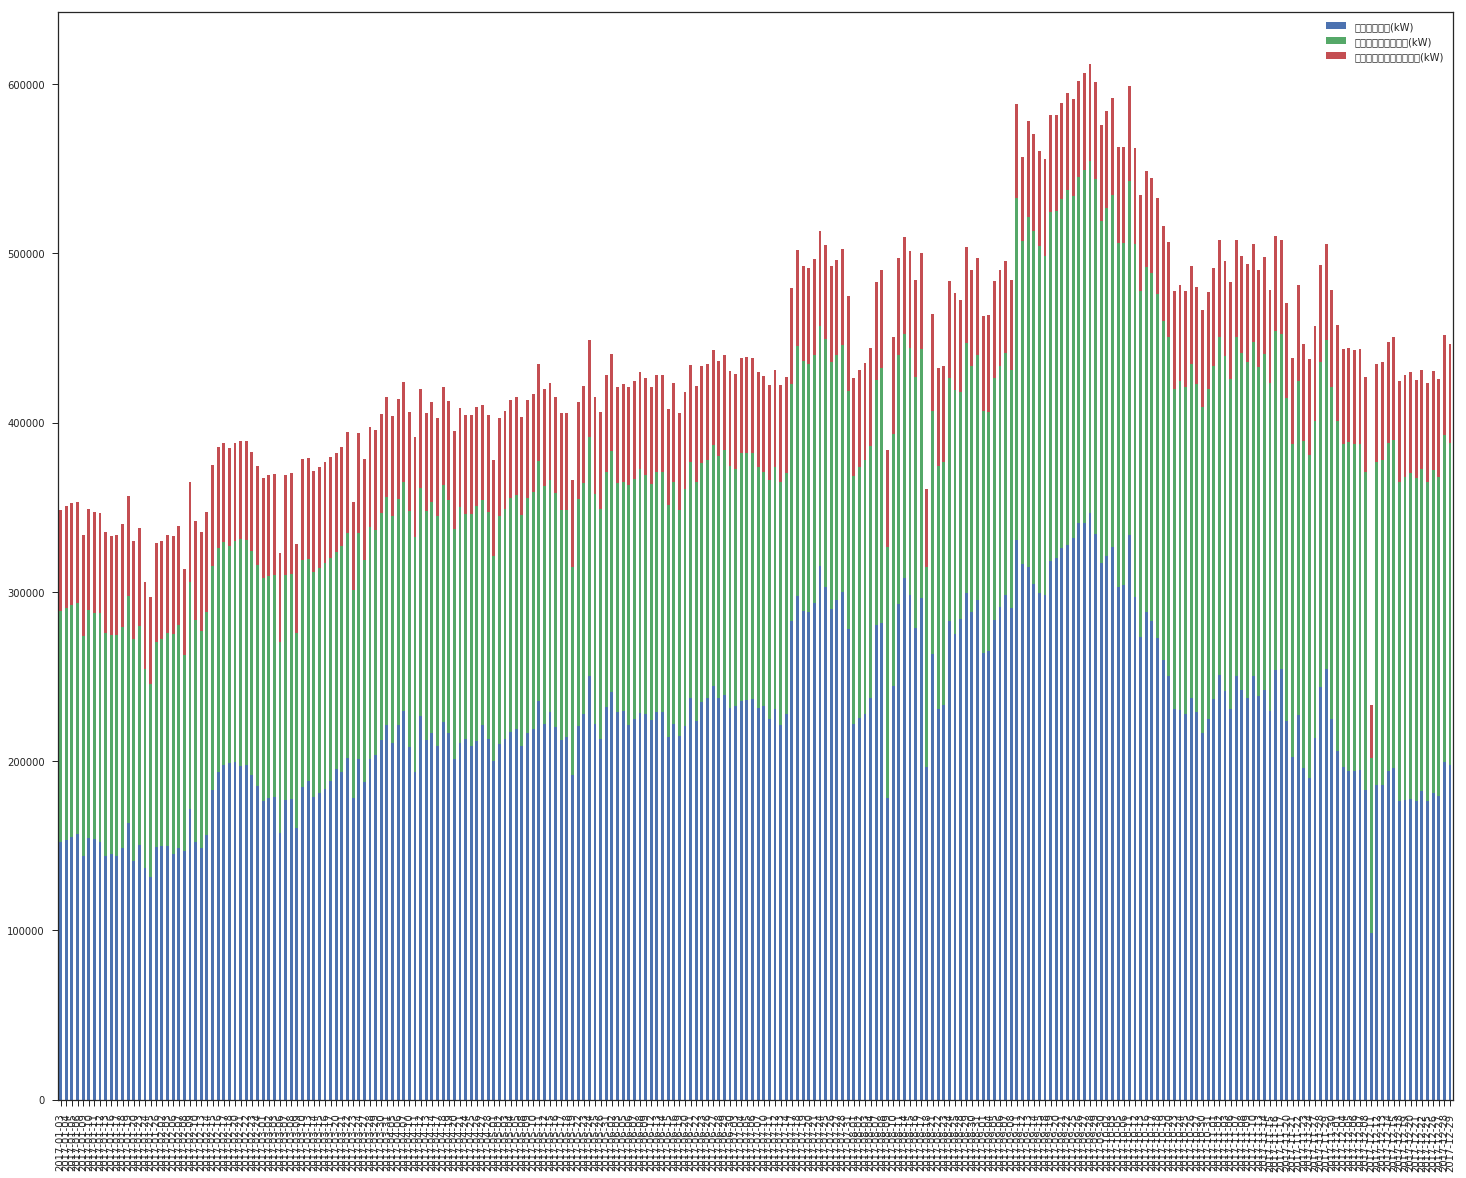

In [99]:
tableV = Table_sta_vis()
tableV.bar(qd.SQL_table[4], size=(25,20), stacked=True)

# 備註：刪掉某一個group table (如果不想重新宣告物件)

In [100]:
qd.SQL_table_info

{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum']),
 2: ('行政用電_hour.csv', 'workday', ['date', 0, 'sum']),
 3: ('行政用電.csv', 'holiday', ['date', 0, 'sum']),
 4: ('行政用電.csv', 'workday', ['date', 0, 'sum'])}

In [101]:
# 選號碼去刪掉
qd.del_SQL_table(no=2)

{1: ('行政用電_hour.csv', 'holiday', ['date', 0, 'sum']), 2: ('行政用電.csv', 'holiday', ['date', 0, 'sum']), 3: ('行政用電.csv', 'workday', ['date', 0, 'sum'])}


In [53]:
#idx=[1, 7, 9, 13, 14]
#for i in idx:
#    print(qd.SQL_table[1].columns[i])

In [54]:
#new_table = pd.DataFrame()
#idx=[1, 7, 9]
#for i in idx:
#    new_table[qd.SQL_table[1].columns[i]] = qd.SQL_table[1][qd.SQL_table[1].columns[i]]

In [55]:
#tableV = Table_sta_vis()
#tableV.line(new_table, size=(20,8))